# <div style='color:white;background: #005792;text-align: center;padding: 15px 0'>Recommandations - Modélisation d'un modèle machine learning avec Autoencodeur</div>

## Participants
* Samantha
* Rachelle
* Andrew

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Configuration des variables globales</a></div>

### Installation des librairies

In [3]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install plotly-express
# !pip install plotly

# !pip install scikit-learn
# !pip install tensorflow

### Importation des librairies

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

### Chargement des fichiers

In [3]:
source_dir= '/home/dstrec/dstrec/010_data/002_merged'

file_final = f"{source_dir}/dstrec.csv"

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Préparation des données</a></div>

### Chargement des jeux de données

In [4]:
df = pd.read_csv(file_final)

### Calcul de la note moyenne pondérée (WAR)

In [5]:
C = df['averageRating'].mean()
m = df['numVotes'].quantile(0.90)

def weighted_average_rating(x, m=m, C=C):
    v = x['numVotes']
    R = x['averageRating']
    return (v/(v + m) * R) + (m/(m + v) * C)

df['weightedAverageRating'] = df.apply(weighted_average_rating, axis=1)

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Préparation des caractéristiques basées sur le contenu et les utilisateurs</a></div>

### Encodage one-hot pour les colonnes catégorielles

In [6]:
df = df.drop(['imdbId'], axis=1)

categorical_features = ['director', 'actor_actress', 'producer']
numeric_features = [col for col in df.columns if col not in categorical_features + ['title']]

numeric_transformer = MaxAbsScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
    sparse_threshold=0.5)

content_features = preprocessor.fit_transform(df.drop('title', axis=1))

### Normaliser les caractéristiques des films avec MaxAbsScaler

In [7]:
scaler = MaxAbsScaler()
scaled_features = scaler.fit_transform(content_features)

### Réduction de la dimensionnalité avec TruncatedSVD

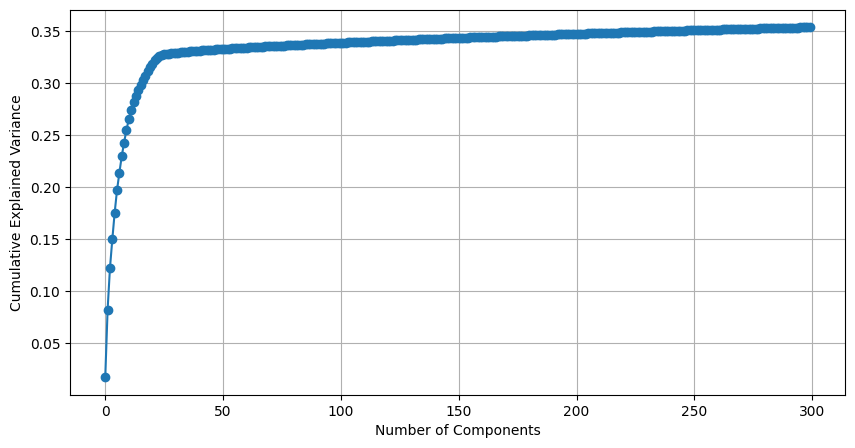

Variance expliquée avec 300 composantes: 0.35404343436522856


In [9]:
# Fixation du nombre de composantes pour SVD
fixed_components = 300

# Application de TruncatedSVD avec le nombre de composantes fixé
svd = TruncatedSVD(n_components=fixed_components)
reduced_features = svd.fit_transform(scaled_features)

# Variance expliquée cumulée
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

# Plot pour visualiser la variance expliquée
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

print(f"Variance expliquée avec {fixed_components} composantes: {cumulative_variance[fixed_components - 1]}")

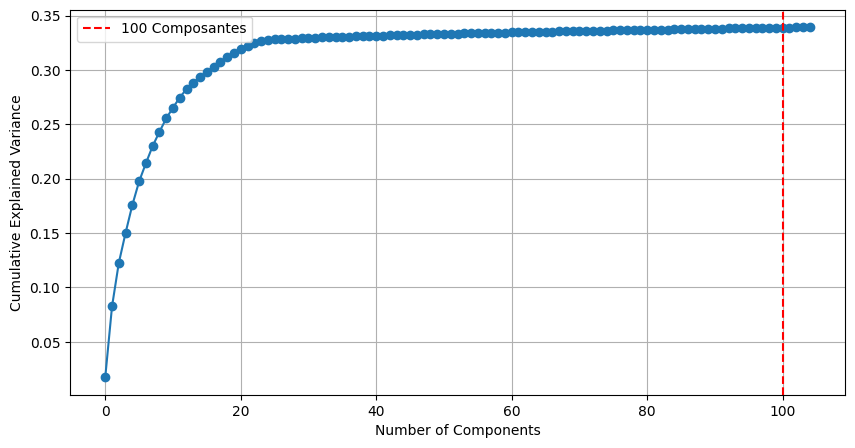

Variance expliquée avec 100 composantes: 0.3392802369377463


In [7]:
# Fixation du nombre de composantes pour SVD
fixed_components = 105

# Application de TruncatedSVD avec le nombre de composantes fixé
svd = TruncatedSVD(n_components=fixed_components)
reduced_features = svd.fit_transform(scaled_features)

# Variance expliquée cumulée
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o')
plt.axvline(x=100, color='r', linestyle='--', label='100 Composantes')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid()
plt.show()

print(f"Variance expliquée avec 100 composantes: {cumulative_variance[fixed_components - 1]}")

<b>Choix des Composantes</b><br>
Nous avons observé que la variance expliquée par les composantes supplémentaires commence à stagner après un certain point. Plus précisément, la variance expliquée avec 100 composantes est de 33.88% alors qu'elle n'est que de 35.40% avec 300 composantes. L'augmentation marginale de la variance expliquée ne justifie pas la complexité computationnelle supplémentaire d'utiliser plus de composantes.

<b>Justification du Choix</b><br>
L'objectif est de trouver un équilibre entre la complexité du modèle et la performance. Avec 100 composantes, nous capturons déjà une grande partie de la variance dans les données (33.88%), et la différence avec le maximum atteint par 300 composantes (35.40%) est minime.

In [8]:
# Fixation du nombre de composantes pour SVD
fixed_components = 100

# Application de TruncatedSVD avec le nombre de composantes fixé
svd = TruncatedSVD(n_components=fixed_components)
reduced_features = svd.fit_transform(scaled_features)

# Variance expliquée cumulée
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

### Division des données en ensembles d'entraînement et de test

In [9]:
train_data, test_data = train_test_split(reduced_features, test_size=0.2, random_state=42)

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Construction et Entraînement de l'Autoencodeur</a></div>

In [10]:
# Normalisation des données
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data)

# Définition des dimensions
input_dim = train_data_normalized.shape[1]
encoding_dim = 64

# Entrée de l'autoencodeur
input_layer = Input(shape=(input_dim,))

# Encodeur
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dropout(0.2)(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dense(encoding_dim, activation='relu')(encoder)
encoder = Dropout(0.2)(encoder)
encoder = BatchNormalization()(encoder)

# Décodeur
decoder = Dense(128, activation='relu')(encoder)
decoder = Dropout(0.2)(decoder)
decoder = BatchNormalization()(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)

# Modèle
autoencoder = Model(input_layer, decoder)
autoencoder.summary()

# Compilation du modèle
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Utilisation de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement l'autoencodeur
history = autoencoder.fit(train_data_normalized, train_data_normalized,
                          epochs=12,  # Limitation du nombre d'époques à 12
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2,
                          callbacks=[early_stopping])  # Utilisation EarlyStopping pour arrêter si la performance stagne

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,684 (170.64 KB)

 Trainable params: 43,044 (168.14 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1535 - val_loss: 0.0052
Epoch 2/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 3/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 4/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 5/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 6/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0047 - val_loss: 0.0047


## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Évaluation et Visualisation du Modèle</a></div>

### Vérification des données après normalisation

Min value in train data: -1.2444726948010125
Max value in train data: 1.8750122526848938


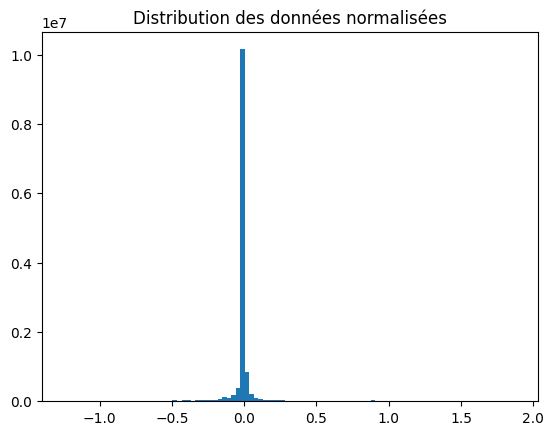

In [13]:
print("Min value in train data:", np.min(train_data))
print("Max value in train data:", np.max(train_data))

plt.hist(train_data.flatten(), bins=100)
plt.title("Distribution des données normalisées")
plt.show()

### Prédictions

1026/1026 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step
Mean Squared Error: 1.0016690492630005


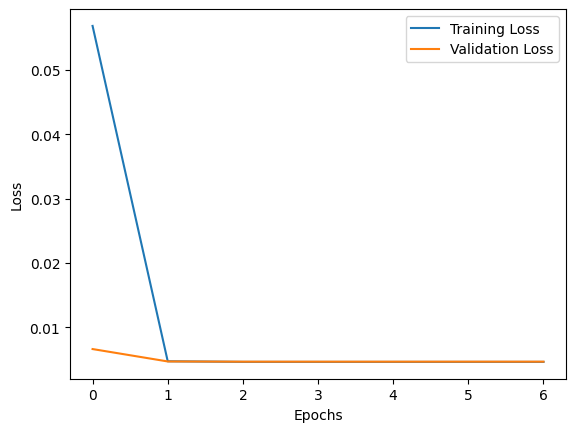

In [14]:
predictions = autoencoder.predict(test_data)

# Calcule de l'erreur de reconstruction
mse = tf.keras.losses.MeanSquaredError()
error = mse(test_data, predictions).numpy()
print(f"Mean Squared Error: {error}")

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

 prédiction sur des données de test 

In [16]:
# Normalisation des données de test
test_data_normalized = scaler.transform(test_data)

# Prédiction des données de test
test_predictions = autoencoder.predict(test_data_normalized)

# Évaluation la performance
test_loss = autoencoder.evaluate(test_data_normalized, test_data_normalized)
print(f'Test Loss: {test_loss}')


1026/1026 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step - loss: 0.0046
Test Loss: 0.004633432719856501


Le modèle a obtenu une perte de test (Test Loss) de 0.0046, ce qui est très proche de la perte de validation observée pendant l'entraînement. Cela indique que le modèle généralise bien sur les données de test et qu'il n'y a pas de signes évidents de surapprentissage.

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Génération des Recommandations</a></div>

In [11]:
# Encodage des données d'entraînement et l'ensemble complet des données
encoded_train_data = autoencoder.predict(train_data)
encoded_full_data = autoencoder.predict(reduced_features)

# Fonction de normalisation
def normalize(x):
    norm = np.linalg.norm(x)
    if norm == 0: 
       return x
    return x / norm

# Normalisation les représentations encodées
normalized_encoded_full_data = np.apply_along_axis(normalize, 1, encoded_full_data)

# Obtention toutes les colonnes de genres
genre_columns = df.loc[:, 'Action':'Western'].columns

# Création une fonction de recommandation pour chaque film
def recommend_movies(movie_title, num_recommendations=5):
    if movie_title not in df['title'].values:
        return f"Le film '{movie_title}' n'existe pas dans la base de données."

    movie_index = df.index[df['title'] == movie_title].tolist()[0]
    movie_ratings = normalized_encoded_full_data[movie_index]

    # Calcule ces similarités cosinus entre le film donné et tous les autres films
    similarities_cosine = np.dot(normalized_encoded_full_data, movie_ratings)

    # Vérification des genres des films recommandés pour plus de pertinence
    original_genres = df.loc[movie_index, genre_columns].values
    similar_movies = df.loc[:, genre_columns].copy()

    # Filtre des recommandations pour inclure des films avec des genres similaires
    similar_movies['genre_similarity'] = similar_movies.apply(
        lambda row: np.dot(row.values, original_genres), axis=1)

    # Combination des scores de similarité
    combined_score = (0.5 * similarities_cosine) + (0.5 * similar_movies['genre_similarity'].values)
    similar_movies['combined_score'] = combined_score

    # Trie des films par score combiné, exclure le film donné, et retourner les meilleurs
    similar_indices = similar_movies['combined_score'].argsort()[-(num_recommendations + 1):][::-1]
    similar_indices = [idx for idx in similar_indices if idx != movie_index][:num_recommendations]

    final_recommendations = df.loc[similar_indices]

    return final_recommendations['title']

4103/4103 ━━━━━━━━━━━━━━━━━━━━ 3s 698us/step
5129/5129 ━━━━━━━━━━━━━━━━━━━━ 3s 670us/step


## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Exemples d'utilisations</a></div>

### Star Trek

In [43]:
print(recommend_movies('Star Trek', 5))

(87495                   The Fist of Death
34397                         Time Runner
116092    Transformers: Age of Extinction
70615                        Transformers
111578           The Amazing Spider-Man 2
Name: title, dtype: object, [87495, 34397, 116092, 70615, 111578], 77273)


### Rogue One: A Star Wars Story

In [13]:
print(recommend_movies('Rogue One: A Star Wars Story', 5))

87495                   The Fist of Death
34397                         Time Runner
116092    Transformers: Age of Extinction
70615                        Transformers
111578           The Amazing Spider-Man 2
Name: title, dtype: object


### Star Wars: Episode VII - The Force Awakens

In [14]:
print(recommend_movies('Star Wars: Episode VII - The Force Awakens', 5))

87495                   The Fist of Death
34397                         Time Runner
116092    Transformers: Age of Extinction
70615                        Transformers
111578           The Amazing Spider-Man 2
Name: title, dtype: object


### Serenity

In [15]:
print(recommend_movies('Serenity', 5))

87495                   The Fist of Death
34397                         Time Runner
116092    Transformers: Age of Extinction
70615                        Transformers
111578           The Amazing Spider-Man 2
Name: title, dtype: object


### Jumanji

In [16]:
print(recommend_movies('Jumanji', 5))

141878    Vinski and the Invisibility Powder
73348                                   Hoot
43                  The Patchwork Girl of Oz
63719                       A Christmas Tail
3957                Blondie Takes a Vacation
Name: title, dtype: object


### Toy Story

In [17]:
print(recommend_movies('Toy Story', 5))

139316       Playmobil: The Movie
163353    The Adventures of Açela
35214              The Pagemaster
156367                The Mobarak
91399      Two by Two: Overboard!
Name: title, dtype: object
